In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import ticker
from matplotlib import colors
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

	float botpres(time_counter, y, x) ;
		botpres:standard_name = "sea_water_pressure_at_sea_floor" ;
		botpres:long_name = "Pressure at sea floor" ;
		botpres:units = "dbar" ;
		botpres:online_operation = "average" ;
		botpres:interval_operation = "120 s" ;
		botpres:interval_write = "1 h" ;
		botpres:cell_methods = "time: mean (interval: 120 s)" ;
		botpres:_FillValue = 1.e+20f ;
		botpres:missing_value = 1.e+20f ;
		botpres:coordinates = "time_centered nav_lon nav_lat" ;

In [22]:
def get_vars_at_depth(dirname, time_ind):
    
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    maskname = '1_mesh_mask.nc'
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(filesT) as dsT:
        botpres = dsT.variables['botpres'][time_ind,y,x]

    with nc.Dataset(os.path.join(dirname, maskname), 'r') as dsM:
        mbathy = dsM.variables['mbathy'][0,y,x]
        tmask = dsM.variables['tmask'][0,:,y,x]
        e3u = dsM.variables['e3u_0'][0, :, y, x]
    
    return botpres, mbathy, tmask, e3u

In [23]:
dirnameI = '/ocean/imachuca/Canyons/results_mackenzie/initial_collection/botpress_ideal_half/'
dirnameR = '/ocean/imachuca/Canyons/results_mackenzie/initial_collection/botpress_real_half/'

time_ind = 24

botpresI, mbathyI, tmaskI, e3uI = get_vars_at_depth(dirnameI, time_ind)
botpresR, mbathyR, tmaskR, e3uR = get_vars_at_depth(dirnameR, time_ind)

In [24]:
botpresI.shape, mbathyI.shape, tmaskI.shape, e3uI.shape

((272, 242), (272, 242), (80, 272, 242), (80, 272, 242))

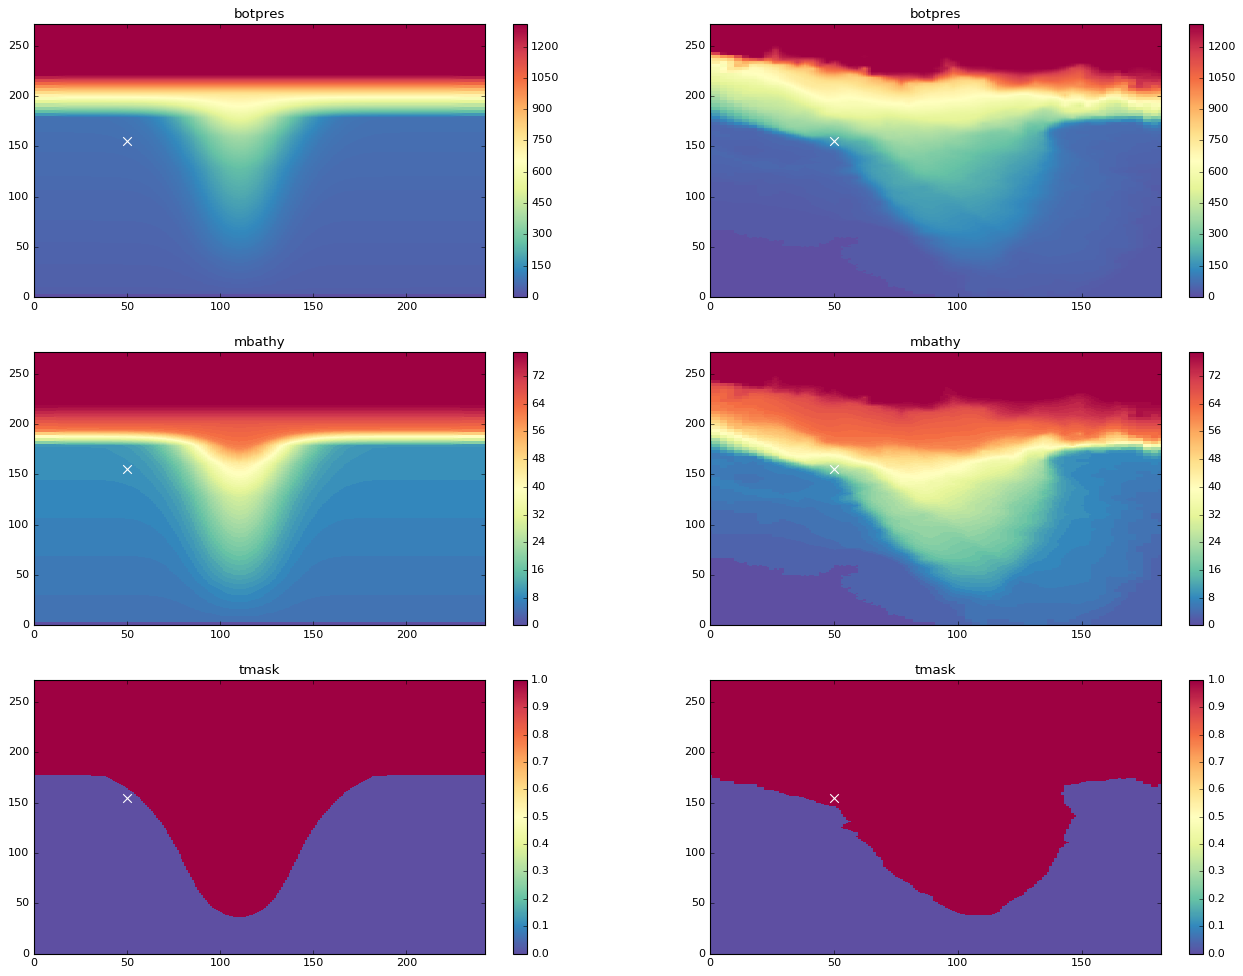

In [55]:
fig, (axA, axB, axC) = plt.subplots(3, 2, figsize=(20, 15))
    
def this_subplot(ax, n, plot, ttl):
    p = ax[n].pcolormesh(plot, cmap=cm.Spectral_r)
    fig.colorbar(p, ax=ax[n])
    ax[n].set_title(ttl)
    ax[n].set_ylim([0, plot.shape[-2]])
    ax[n].set_xlim([0, plot.shape[-1]])
    ax[n].scatter(50, 155, c='w', s=60, marker='x')
    
for n, plot in zip(np.arange(2), [botpresI, botpresR]):
    this_subplot(axA, n, plot, 'botpres')
    
for n, plot in zip(np.arange(2), [mbathyI, mbathyR]):
    this_subplot(axB, n, plot, 'mbathy')
    
for n, plot in zip(np.arange(2), [tmaskI[9, ...], tmaskR[9, ...]]):
    this_subplot(axC, n, plot, 'tmask')

In [57]:
tmaskI[9, 155, 50], tmaskR[9, 155, 50]

(0, 1)

In [58]:
mbathyI[155, 50], mbathyR[155, 50]

(9, 22)

In [61]:
tmaskI[9, 155, 50], tmaskR[22, 155, 50]

(0, 0)

mbathy gives the first dry cell

In [62]:
e3uI_bot = np.full_like(mbathyI, np.nan)
e3uR_bot = np.full_like(mbathyR, np.nan)

for j in range(mbathyI.shape[-2]):
    for i in range(mbathyI.shape[-1]):
        
        zmI = mbathyI[j, i] - 1 # cell above bot
        e3uI_bot[j, i] = e3uI[zmI, j, i]

for j in range(mbathyR.shape[-2]):
    for i in range(mbathyR.shape[-1]):
        
        zmR = mbathyR[j, i] - 1 # cell above bot
        e3uR_bot[j, i] = e3uR[zmR, j, i]


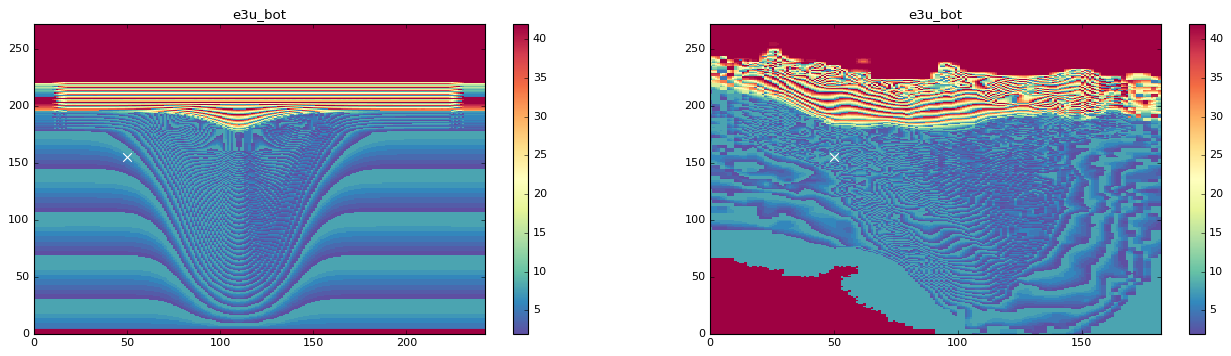

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for n, plot in zip(np.arange(2), [e3uI_bot, e3uR_bot]):
    this_subplot(ax, n, plot, 'e3u_bot')

In [68]:
botpresI.shape, e3uI_bot.shape

((272, 242), (272, 242))

In [69]:
drag_cellsI = botpresI * e3uI_bot
drag_cellsR = botpresR * e3uR_bot

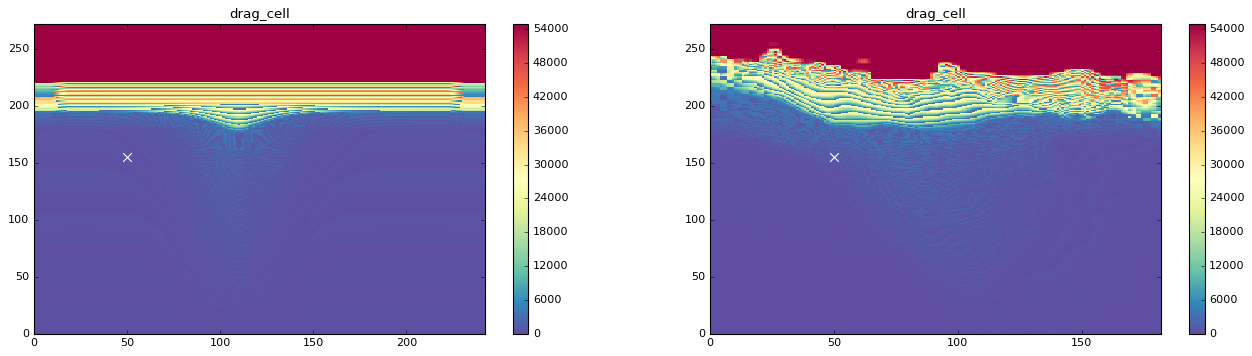

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for n, plot in zip(np.arange(2), [drag_cellsI, drag_cellsR]):
    this_subplot(ax, n, plot, 'drag_cell')